### Imports

In [1]:
from data_functions import get_LSTM_SSA, get_LAMP_SSA, get_SC_SSA
import copy
import os
import logging
import traceback

# sys.path.insert(1, "H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM")

import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from plot_lstm_results import plot_lstm_results
from network_models import LSTM
from train_test import train, test
from S2LDataset import S2LDataset
from print_error_report import print_error_report
from objective_functions import objective_function

# On the line below, specifiy after "from" which file the user inputs are coming from.
from input_template import (
    UserInputArgs,
    PlottingArgs,
    DataInfoArgs,
    SaveDataArgs,
    DerivedArgs,
)
from load_and_standardize import load_and_standardize
from reshape_for_time_resolution import reshape_for_time_resolution, reshape_full_series
from save_lstm import save_lstm_info, load_lstm_info
from save_lstm_results import save_lstm_results
from unstandardize_all_data import unstandardize_all_data

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt

### Description
Train MED LSTM on 10 random samples for each bucket.  Test that against the original LSTM.

### Functions

In [2]:
print("Cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    torch.cuda.empty_cache()  # to avoid some rare errors.

# Check if using CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set parameters
args = UserInputArgs()
plot_args = PlottingArgs()
data_info_args = DataInfoArgs()
save_data_args = SaveDataArgs()

# args.training_mode = False

# Load original LSTM
args.model_load_filename = 'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\MED LSTM\\MED2_30'
network, std_factors = load_lstm_info(args)
network.to(device)

Cuda available: True
Loading LSTM Saved in:  H:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\Experiment_ARCHIVE\MED LSTM\MED2_30 .pickle


LSTM(
  (lstm): LSTM(4, 30, num_layers=2, batch_first=True)
  (linear): Linear(in_features=30, out_features=3, bias=True)
)

In [3]:
def generateOutput(experiment, n=50, train_mode=False, save_folder=''):
    """Given an experiment and training sample size, generate and save output files"""
    print("EXPERIMENT: ", experiment)
    # Create list of eligible files to train on
    exp_PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\{experiment}'
    files = [f for f in os.listdir(exp_PATH + '\\LAMP_files') if f.endswith('1.mot')]

    # Establish test files list (since we're testing on all in a folder)
    test_files = [f.replace('1.mot','3.mot') for f in files]
    # test_files = files
    data_info_args.test_lamp = [exp_PATH + '\\LAMP_files\\' + f.removesuffix('.mot') for f in test_files]
    data_info_args.test_sc = [exp_PATH + '\\SimpleCode_files\\' + f.replace('LAMP','SC').removesuffix('.mot') for f in test_files]

    # Copy the MED LSTM
    model = copy.deepcopy(network)

    # Setup GPU Support
    print("Cuda available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # to avoid some rare errors.

    # Check if using CPU or GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    # randomly select N num_files
    train_files = np.random.choice(files, size=n, replace = False)
    val_files = [f.replace('1.mot','2.mot') for f in train_files]
    # Shorten val_files to 20% of train_files
    val_files = np.random.choice(val_files, size=int(.2*len(val_files)), replace = False)

    # establish the lamp and sc training file paths
    data_info_args.train_lamp = [exp_PATH + '\\LAMP_files\\' + f.removesuffix('.mot') for f in train_files]
    data_info_args.train_sc = [exp_PATH + '\\SimpleCode_files\\' + f.replace('LAMP','SC').removesuffix('.mot') for f in train_files]

    # establish the lamp and sc validation file paths
    data_info_args.val_lamp= [exp_PATH + '\\LAMP_files\\' + f.removesuffix('.mot') for f in val_files]
    data_info_args.val_sc = [exp_PATH + '\\SimpleCode_files\\' + f.replace('LAMP','SC').removesuffix('.mot') for f in val_files]

    # Setup Derived Args
    derived_args = DerivedArgs(args, data_info_args)
    derived_args.test_batch_size = int(derived_args.num_test_realizations * args.time_res / 9)
    # print("No of train realizations: ", derived_args.num_train_realizations)
    # print("No of val realizations: ", derived_args.num_val_realizations)
    # print("No of test realizations: ", derived_args.num_test_realizations)
    # print("No of realizations: ", derived_args.num_realizations)
    # print("Train batch size: ", derived_args.train_batch_size)
    # print("Val batch size: ", derived_args.val_batch_size)
    # print("Test batch size: ", derived_args.test_batch_size)

    # Load the training and validation data
    train_input, train_target, train_sc = load_and_standardize(data_info_args.train_sc, data_info_args.train_lamp, args, std_factors)
    val_input, val_target, val_sc = load_and_standardize(data_info_args.val_sc, data_info_args.val_lamp, args, std_factors)
    test_input, test_target, test_sc = load_and_standardize(data_info_args.test_sc, data_info_args.test_lamp, args, std_factors)

    # Reshape the data to take into account the time resolution
    train_input, train_target = reshape_for_time_resolution(train_input, train_target, args)
    val_input, val_target = reshape_for_time_resolution(val_input, val_target, args)
    test_input, test_target = reshape_for_time_resolution(test_input, test_target, args)

    # Create Dataset objects for each of our train/val/test sets
    train_dataset = S2LDataset(train_input, train_target)
    val_dataset = S2LDataset(val_input, val_target)
    test_dataset = S2LDataset(test_input, test_target)

    # Create a PyTorch dataloader for each train/val set. Test set isn't needed until later
    train_loader = DataLoader(train_dataset, batch_size=derived_args.train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=derived_args.val_batch_size)

    # Create testing dataloader
    test_loader = DataLoader(test_dataset, batch_size=derived_args.test_batch_size)

    # Display dataset information
    # print("\nReshaped the following data:")
    # print(f"train_input has shape	{train_input.shape}")
    # print(f"train_target has shape	{train_target.shape}")
    # print(f"val_input has shape 	{val_input.shape}")
    # print(f"val_target has shape 	{val_target.shape}")
    # print(f"test_input has shape 	{test_input.shape}")
    # print(f"test_target has shape 	{test_target.shape}")
    realization_length = train_input.shape[1] * args.time_res

    # initialize our optimizer. We'll use Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    # Begin Training
    if train_mode == True:
        best_val_loss = float("inf")
        best_loss_counter = 0
        print("\n Beginning Training")
        start_time = time.time()
        for epoch in range(1, args.epochs + 1):
            train_loss = train(model, device, train_loader, optimizer, args.train_fun_hyp)
            val_loss = test(model, device, val_loader, args.val_fun_hyp)
            if val_loss < 0.95 * best_val_loss:
                best_val_loss = val_loss
                best_loss_counter = 0
                torch.save(model.state_dict(), "recently_trained_model.pt")
            else:
                best_loss_counter += 1
            if best_loss_counter > 30:
                break
            # print("Train Epoch: {:02d} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tCounter: {:02d}".format(epoch, train_loss, val_loss, best_loss_counter))
        print("Training Done\n")
        end_time = time.time()
        trainTime = end_time - start_time
        print("Training Time: ", trainTime)
        model.load_state_dict(torch.load("recently_trained_model.pt"))  # restoring the best found network based on validation data

    start_time = time.time()
    train_lstm_output = test(model,device,train_loader,args.val_fun_hyp,derived_args.num_train_realizations,args.time_res,True,)
    val_lstm_output = test(model,device,val_loader,args.val_fun_hyp,derived_args.num_val_realizations,args.time_res,True,)
    test_lstm_output = test(model,device,test_loader,args.val_fun_hyp,derived_args.num_test_realizations,args.time_res,True,)
    end_time = time.time()
    testTime = end_time - start_time
    print("Testing Time: ", testTime)
    print("\ntrain output shape", train_lstm_output.shape)
    print("val output shape  ", val_lstm_output.shape)
    print("test output shape ", test_lstm_output.shape)
    print("Time to produce output for ",derived_args.num_realizations," realizations:",(end_time - start_time),)

    # Reshape our input and targets to be same shape as output
    train_input, train_target, train_lstm_output = reshape_full_series(train_input, train_target, train_lstm_output, args)
    val_input, val_target, val_lstm_output = reshape_full_series(val_input, val_target, val_lstm_output, args)
    test_input, test_target, test_lstm_output = reshape_full_series(test_input, test_target, test_lstm_output, args)

    # Unstandardize
    train_target, train_lstm_output = unstandardize_all_data(train_target, train_lstm_output, std_factors, args)
    val_target, val_lstm_output = unstandardize_all_data(val_target, val_lstm_output, std_factors, args)
    test_target, test_lstm_output = unstandardize_all_data(test_target, test_lstm_output, std_factors, args)

    # Print error report
    print("\nLSTM Error Results:")
    print_error_report(train_lstm_output,val_lstm_output,test_lstm_output,train_target,val_target,test_target,args,)
    
    # Save the output
    save_data_args.test = list(range(0,len(data_info_args.test_sc)))
    save_data_args.output_path = exp_PATH + f'\\{save_folder}\\'
    print("Saving output to ",save_data_args.output_path)
    save_lstm_results(train_lstm_output,val_lstm_output,test_lstm_output,save_data_args,data_info_args,args,std_factors,)
    print('')

In [4]:
PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\'
ignore = ['Cases_files', '.ipynb_checkpoints','SecAngleOnly_test','__pycache__']
for exp in os.listdir(PATH):
    if os.path.isdir(PATH + exp) and exp not in ignore:
        try:
            generateOutput(exp,n=10,train_mode=True,save_folder='output_files_MED2_30_10')
        except Exception as e:
            logging.error(traceback.format_exc())
            print('ERROR in ', exp)
            continue

EXPERIMENT:  aavs
Cuda available: True
full series simple (input) shape  (10, 17990, 4)
full series lamp (target) shape  (10, 17990, 3)
full series simple (input) shape  (2, 17990, 4)
full series lamp (target) shape  (2, 17990, 3)
full series simple (input) shape  (216, 17990, 4)
full series lamp (target) shape  (216, 17990, 3)

 Beginning Training
Training Done

Training Time:  147.5040407180786
Testing Time:  2.39406156539917

train output shape (90, 1998, 3)
val output shape   (18, 1998, 3)
test output shape  (1944, 1998, 3)
Time to produce output for  228  realizations: 2.39406156539917

LSTM Error Results:
--------------------------------------------
Training Data Errors:
MSE:                  tensor(37.2287, dtype=torch.float64)
Amplitude Magnified:  tensor(3891.8612, dtype=torch.float64)
Peak MSE:             tensor(49.0948, dtype=torch.float64)
--------------------------------------------
Validation Data Errors:
MSE:                  tensor(0.7021, dtype=torch.float64)
Amplitud

ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_3816\1341147570.py", line 6, in <module>
    generateOutput(exp,n=10,train_mode=True,save_folder='output_files_MED2_30_10')
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_3816\2516275336.py", line 55, in generateOutput
    test_input, test_target, test_sc = load_and_standardize(data_info_args.test_sc, data_info_args.test_lamp, args, std_factors)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\load_and_standardize.py", line 48, in load_and_standardize
    lstm_inputs, target_outputs = load_fullseries(
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\load_and_standardize.py", line 38, in load_fullseries
    np.concatenate((simple_vbm_data, simple_motion_data, wave_data), axis=1)
  File "<__array_function__ internals>", line 180, in concatenate
ValueError: all the input array dimensions for the concatena

ERROR in  hvp
EXPERIMENT:  hvpp
Cuda available: True
full series simple (input) shape  (10, 17990, 4)
full series lamp (target) shape  (10, 17990, 3)
full series simple (input) shape  (2, 17990, 4)
full series lamp (target) shape  (2, 17990, 3)
full series simple (input) shape  (81, 17990, 4)
full series lamp (target) shape  (81, 17990, 3)

 Beginning Training
Training Done

Training Time:  122.1652159690857
Testing Time:  1.4337351322174072

train output shape (90, 1998, 3)
val output shape   (18, 1998, 3)
test output shape  (729, 1998, 3)
Time to produce output for  93  realizations: 1.4337351322174072

LSTM Error Results:
--------------------------------------------
Training Data Errors:
MSE:                  tensor(7.5064, dtype=torch.float64)
Amplitude Magnified:  tensor(901.1186, dtype=torch.float64)
Peak MSE:             tensor(6.4705, dtype=torch.float64)
--------------------------------------------
Validation Data Errors:
MSE:                  tensor(0.4708, dtype=torch.float6

KeyboardInterrupt: 

def LSTMvLAMP_df(experiment="",LSTM_files='', realization=''):
    
    from pathlib import Path
    import pandas as pd

    """Makes a dataframe comparing LSTM and LAMP outputs
        experiment = folder name of the experiment"""

    # Establish paths
    exp_PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\{experiment}\\'

    # network options
    # nwOptions = ('original', 'new')
    
    # No experiment or network given
    if experiment == "" or LSTM_files == '':
        return "INVALID EXPERIMENT OR NETWORK"

    # Parse out the variables observed
    v1 = experiment.partition("v")[0]  # Pulls first variable by taking string before "_", spliting at the "v"
    v2 = experiment.partition("v")[2]  # 2nd variable

    # LAMP path
    LAMP_path = exp_PATH + "\\LAMP_files\\"

    # LSTM data
    exp_PATH += LSTM_files + '\\'

    # Set experiment path
    # if network.lower() == "original":
    #     exp_PATH += "\\output_files_MED\\"
    # elif network.lower() == "new":
    #     exp_PATH += "\\output_files_MED2_30_50\\"

    # Make the dataframe for LSTM
    df_LSTM = pd.DataFrame(
        columns=[v1, v2, "Zcg", "Roll", "Pitch"]
    )  # Create cols for the altered variables in experiement and heave, roll, pitch

    # step through every LSTM file in the experiement to get the SSA, and add to dataframe
    for path in Path(exp_PATH).glob(f"*{realization}.txt"):
        # Get the SSA's
        SSA = get_LSTM_SSA(path)
        # Get the variable combo for the file
        trial = path.name.lstrip("lstm_output_for_SC_")
        idx = trial.partition(v1)[2]
        t1 = idx.partition("_")[0]
        if v2 == "s":
            idx = trial.partition(v2)[2]
            t2 = idx.partition("-")[0]
        else:
            idx = trial.partition(v2)[2]
            t2 = idx.partition("_")[0]

        SSA[v1] = float(t1)
        SSA[v2] = float(t2)

        df_LSTM.loc[len(df_LSTM)] = SSA

    df_LSTM = df_LSTM.sort_values(by=[v1, v2])

    # Make the dataframe for LAMP
    df_LAMP = pd.DataFrame(columns=[v1, v2, "Zcg", "Roll", "Pitch"])

    # step through every LAMP file in the experiement to get the SSA, and add to dataframe
    for path in Path(LAMP_path).glob(f"*{realization}.mot"):
        # Get the SSA's
        SSA = get_LAMP_SSA(path)
        # Get the variable combo for the file
        trial = path.name.lstrip("LAMP_")
        idx = trial.partition(v1)[2]
        t1 = idx.partition("_")[0]
        if v2 == "s":
            idx = trial.partition(v2)[2]
            t2 = idx.partition("-")[0]
        else:
            idx = trial.partition(v2)[2]
            t2 = idx.partition("_")[0]

        SSA[v1] = float(t1)
        SSA[v2] = float(t2)

        df_LAMP.loc[len(df_LAMP)] = SSA

    df_LAMP = df_LAMP.sort_values(by=[v1, v2])

    # Establish new, final DF for heatmap
    df_final = pd.DataFrame(columns=[v1, v2, "Zcg Error", "Roll Error", "Pitch Error"])
    df_final[v1] = df_LSTM[v1]
    df_final[v2] = df_LSTM[v2]

    # find the absolute difference between each in the series
    df_final["Zcg Error"] = np.abs(df_LSTM["Zcg"] - df_LAMP["Zcg"])
    df_final["Roll Error"] = np.abs(df_LSTM["Roll"] - df_LAMP["Roll"])
    df_final["Pitch Error"] = np.abs(df_LSTM["Pitch"] - df_LAMP["Pitch"])

    return df_final, v1, v2

def makeHeatmap(experiment, parameter, realization):
    import seaborn as sns
    """
    Creates a heatmap of SSA error between unimodal LSTM and same LSTM trained with bimodal seas. Given a df of the form:
    v1      v2    Zcg Error       Roll Error    Pitch Error
    experiment = case file
    network = network trained on
    parameter = parameter we want to see
    """

    # Set save path for the figure
    SAVE_PATH = 'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Transfer Learning Figures\\TL10_vs_UniModMED'

    # Set units for color bar
    if parameter == "Zcg Error":
        units = "meters"
    else:
        units = "degrees"

    # Set the fig and ax
    fig, (axo, axn, axd) = plt.subplots(3, figsize=(16, 16), sharey=True)
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
    fig.suptitle(f"{experiment} Absolute SSA {parameter}", fontsize=18)

    # get the Original dataset
    dfo, v1, v2 = LSTMvLAMP_df(experiment, 'output_files_MED', realization)
    resulto = dfo.pivot(index=v2, columns=v1, values=parameter)

    # Set colorbar max value
    vmax = resulto.max().max()

    # get the new dataset
    dfn, v1, v2 = LSTMvLAMP_df(experiment, 'output_files_MED2_30_10', realization)
    resultn = dfn.pivot(index=v2, columns=v1, values=parameter)

    # Set colorbar max value to that of new if it's more than med
    if resultn.max().max() > vmax:
        vmax = resultn.max().max()

    # Plot original dataset
    g1 = sns.heatmap(
        resulto,cmap="Blues",ax=axo,cbar_kws={"label": units},cbar=True,vmax=vmax,cbar_ax=cbar_ax, annot = True, fmt = ".2f"
    )
    g1.invert_yaxis()
    g1.set_title("Unimodal Training")

    # get the new dataset
    g2 = sns.heatmap(
        resultn, cmap="Blues", ax=axn, cbar=True, vmax=vmax, cbar_ax=cbar_ax, annot = True, fmt = ".2f"
    )
    g2.invert_yaxis()
    g2.set_title("Transfer Learning N=10")

    # Plot a heatmap comparing the difference between the two.  Bigger is better b/c delta_orig - delta_new means new performed much better
    dfc = dfn.copy()
    cols =  dfo.columns.difference([v1,v2])
    dfc[cols] = dfo[cols] - dfn[cols]
    resultc = dfc.pivot(index=v2, columns=v1, values=parameter)
    g3 = sns.heatmap(
        resultc, cmap="Blues", ax=axd, cbar=True, vmax=vmax, cbar_ax=cbar_ax, annot = True, fmt = ".2f"
    )
    g3.invert_yaxis()
    g3.set_title("Delta")

    # Save the figure
    plt.savefig(f"{SAVE_PATH}\\{experiment}_TL10_vs_UniModMED_{parameter}_{realization}.png")


In [ ]:
from data_functions import *

KeyboardInterrupt: 

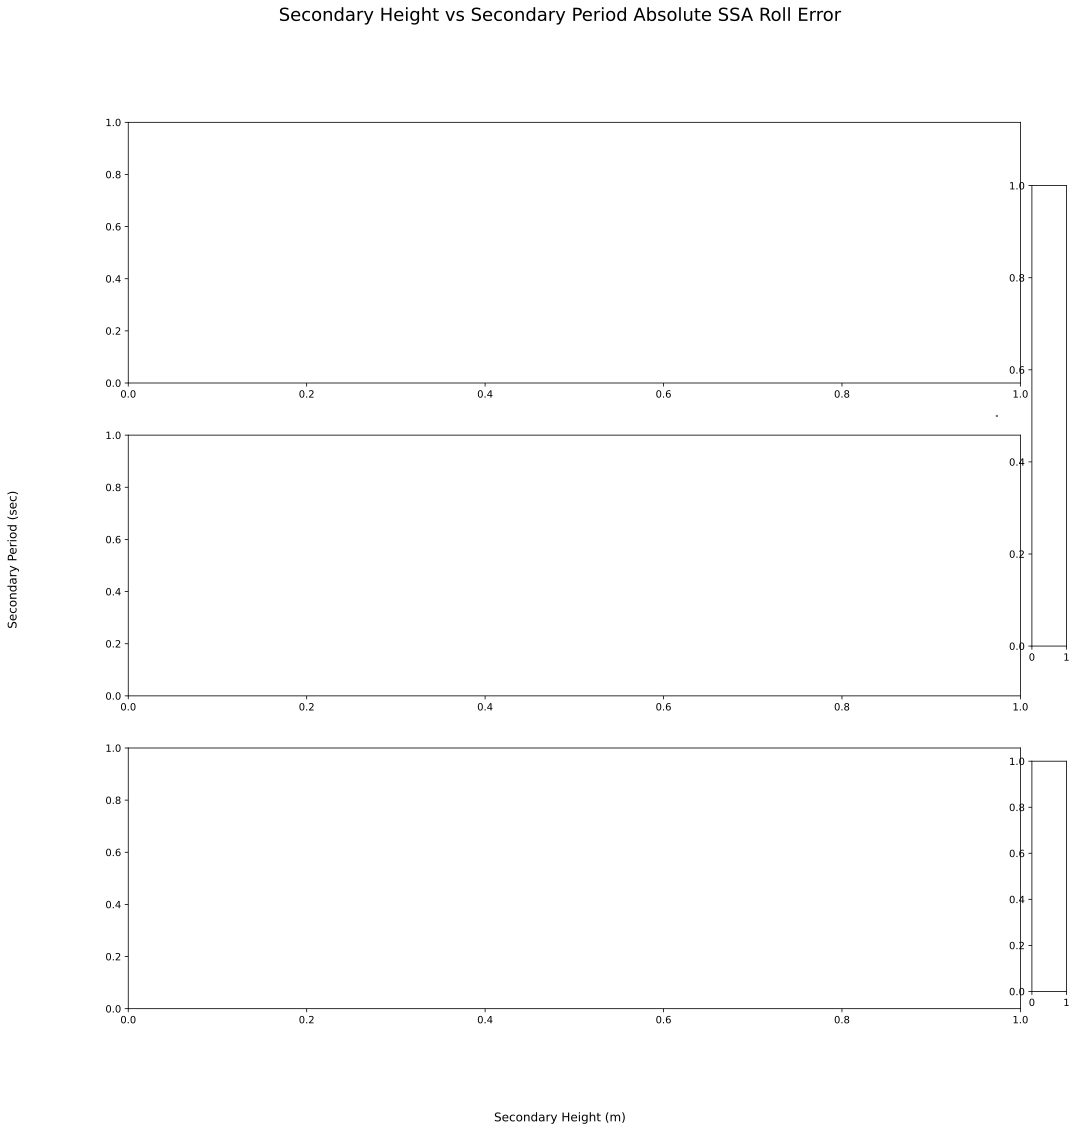

In [ ]:
PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\'
ignore = ['Cases_files', '.ipynb_checkpoints','SecAngleOnly_test','__pycache__']
for exp in os.listdir(PATH):
    if os.path.isdir(PATH + exp) and exp not in ignore:
        try:
            makeHeatmap(top_network='MED2_30_10',bottom_network='MED',experiment=exp, parameter="Zcg Error", realization='3', save_file='TL10_vs_UniModMED')
            plt.close()
            makeHeatmap(top_network='MED2_30_10',bottom_network='MED',experiment=exp, parameter="Roll Error", realization='3', save_file='TL10_vs_UniModMED')
            plt.close()
            makeHeatmap(top_network='MED2_30_10',bottom_network='MED',experiment=exp, parameter="Pitch Error", realization='3', save_file='TL10_vs_UniModMED')
            plt.close()
        except Exception as e:
            logging.error(traceback.format_exc())
            print('ERROR in ', exp)
            continue

### Realization #3